# Traffic Sign Classification using Custom CNN (GTSRB Dataset)

## Objective:
To develop a deep learning model that classifies German traffic signs into 43 categories using a custom-built Convolutional Neural Network (CNN). The goal is to accurately recognize road signs to assist autonomous driving systems.

## Dataset:
- **Name**: GTSRB - German Traffic Sign Recognition Benchmark
- **Source**: [Kaggle - GTSRB Dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data)
- **Total No. of Classes**: 43 classes

## Tools & Technologies:
- Python, NumPy, Pandas
- Keras (CNN modeling)
- OpenCV (image preprocessing)
- Matplotlib, Seaborn (visualization)
- Scikit-learn (model evaluation)

## Workflow:
1. Import required libraries
2. Load and preprocess image data
3. Splitting data into train and validation
4. Data Augmentation
5. Build a custom CNN model with dropout & batch normalization
6. Train model with learning rate scheduling and model checkpointing
7. Model evaluation on test data and visualize the results

## Results:
- **Test Accuracy**: 99.15%
- **Test Loss**: 0.0348
- Model saved as 'gtsrb_final_model.h5' for deployment.

### Importing Libraries

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import cv2
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\anaconda3\envs\traffic_sign_classification\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### Load training data

In [2]:
# Define training dataset path to folders
train_path = 'dataset/Train'

data = []
labels = []
num_classes = len(os.listdir(train_path))   # Get total number of classes from training directory

# loop through each directory and load images
for i in range(num_classes):
    class_path = os.path.join(train_path, str(i))
    images = os.listdir(class_path)

    for img in images:
        try:
            image = cv2.imread(class_path + "/" + img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (32,32))
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading {img}: {e}")

print("Number of classes: {}".format(num_classes))

Number of classes: 43


### Preprocess training data

In [3]:
# Convert data and labels to numpy arrays

data = np.array(data)
labels = np.array(labels)

### Splitting data into training and validation

In [4]:
# split into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, shuffle=True)

print("X training shape: {}".format(x_train.shape))
print("X validation shape: {}".format(x_valid.shape))
print("Y training shape: {}".format(y_train.shape))
print("Y validation shape: {}".format(y_valid.shape))

X training shape: (31367, 32, 32, 3)
X validation shape: (7842, 32, 32, 3)
Y training shape: (31367,)
Y validation shape: (7842,)


In [5]:
# create dictionary of label and corresponding class names

class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

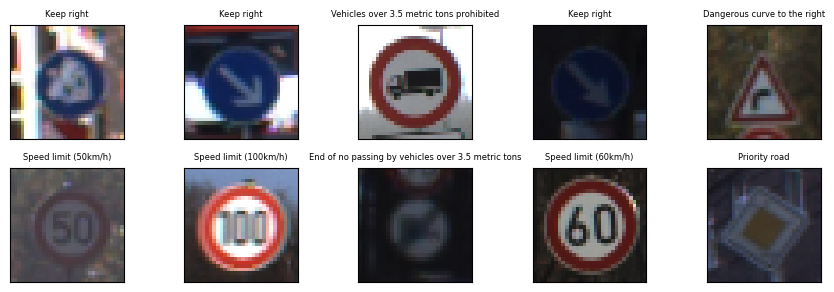

In [6]:
# Visualize 10 training images

plt.figure(figsize=(9,3))
for i in range(10):
    plt.subplot(2, 5, i+1, xticks = [], yticks=[])
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]], fontsize=6)

plt.tight_layout(pad=1.0)
plt.show()

In [7]:
# Normalize images

x_train = x_train.astype("float32")/255.0
x_valid = x_valid.astype("float32")/255.0

# One-hot encode labels

y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)

### Data Augmentation

In [8]:
# Data augmentation for better generalization
train_datagen = ImageDataGenerator(
    rotation_range=0.10,
    zoom_range=0.15,
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(x_train, y_train, batch_size=32)
val_gen = val_datagen.flow(x_valid, y_valid, batch_size=32)

### Build CNN model

In [9]:
# Build CNN model using Keras Sequential API
model = Sequential()

# Convolutional block 1
model.add(Conv2D(16, kernel_size=3, padding='same', strides=1, activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(32, kernel_size=3, padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.25))

# Convolutional block 2
model.add(Conv2D(64, kernel_size=3, padding='same', strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=3, padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.25))

# Convolutional block 3
model.add(Conv2D(256, kernel_size=3, padding='same', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Show model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [10]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training

In [11]:
# add callbacks for training
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("gtsrb_model.h5", save_best_only=True, monitor='val_accuracy', verbose=1)

# train the model
hist = model.fit(train_gen, epochs=40, validation_data=val_gen, callbacks=[lr_reducer, checkpoint], verbose=1)

Epoch 1/40
981/981 [==============================] - ETA: 0s - loss: 3.0342 - accuracy: 0.2110
Epoch 1: val_accuracy improved from -inf to 0.50905, saving model to gtsrb_model.h5
981/981 [==============================] - 126s 127ms/step - loss: 3.0342 - accuracy: 0.2110 - val_loss: 1.4812 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 2/40
981/981 [==============================] - ETA: 0s - loss: 1.3107 - accuracy: 0.5729
Epoch 2: val_accuracy improved from 0.50905 to 0.84621, saving model to gtsrb_model.h5
981/981 [==============================] - 131s 133ms/step - loss: 1.3107 - accuracy: 0.5729 - val_loss: 0.4848 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 3/40
981/981 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.7992
Epoch 3: val_accuracy improved from 0.84621 to 0.95677, saving model to gtsrb_model.h5
981/981 [==============================] - 131s 133ms/step - loss: 0.6238 - accuracy: 0.7992 - val_loss: 0.1154 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 4/40

In [12]:
# save final model
model.save('gtsrb_final_model.h5')

### Training Accuracy and Loss plot

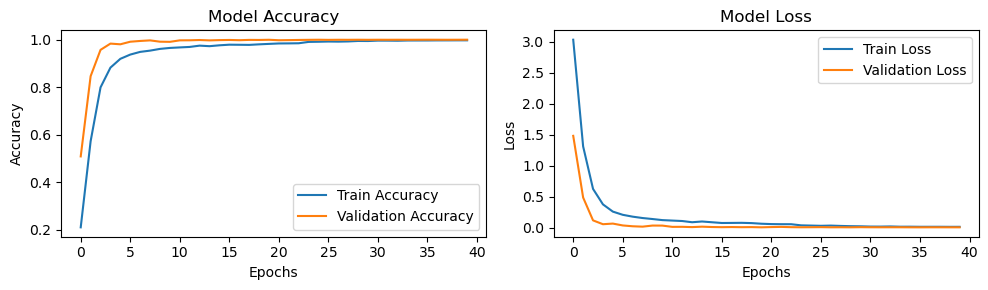

In [13]:
plt.figure(figsize=(10,3))

# plot accuracy
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss
plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Load Test Data

In [14]:
# load test images and its corresponding labels from CSV
test_csv_path = pd.read_csv('dataset/Test.csv')
y_labels = test_csv_path['ClassId'].values
y_imgs = test_csv_path['Path'].values
x_test = []

# load and preprocess test images
for img in y_imgs:
    try:
        img_path = os.path.join('dataset', img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32,32))
        x_test.append(image)
    except Exception as e:
        print(f"Error loading {img} as {e}")

# convert images and labels to test array
x_test = np.array(x_test)
x_test = x_test.astype('float32')/255
y_test = np.array(y_labels)
y_test = to_categorical(y_test, num_classes=num_classes)

### Model evaluation

In [15]:
# predict on test set
preds = model.predict(x_test)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluate model performance
loss, accuracy = model.evaluate(x_test, y_test)
print(f'\nTest Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Accuracy Score: {accuracy_score(y_true, y_pred)*100:.2f}%')

395/395 [==============================] - 9s 22ms/step - loss: 0.0348 - accuracy: 0.9915

Test Loss: 0.0348
Test Accuracy: 0.9915
Accuracy Score: 99.15%


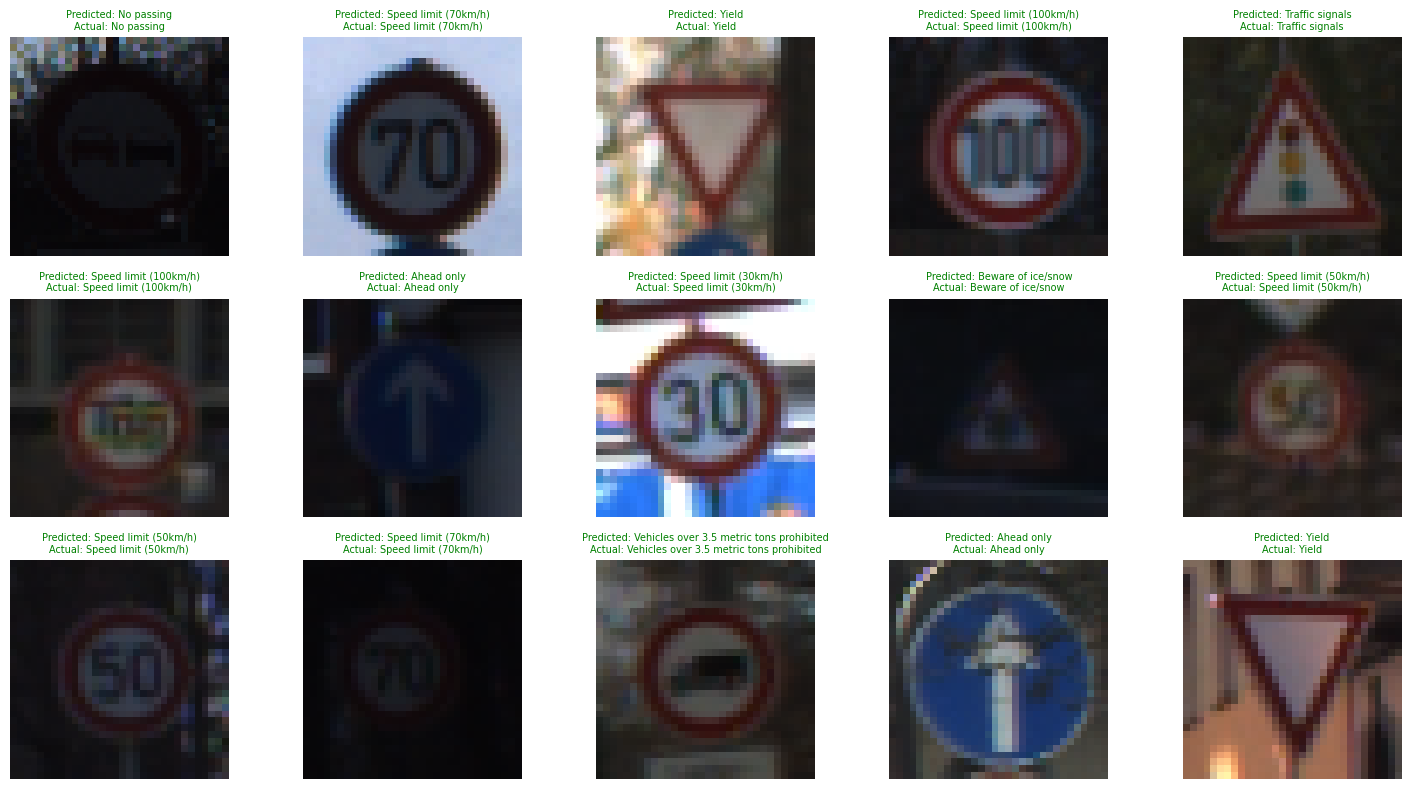

In [16]:
# randomly select 15 images
random_id = random.sample(range(len(x_test)),15)

# display few test images with predictions
plt.figure(figsize=(15,8))
for i, idx in enumerate(random_id):
    plt.subplot(3, 5, i+1, xticks=[], yticks=[])
    plt.imshow(x_test[idx])
    plt.axis('off')
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    color='green' if pred_label == true_label else 'red'
    plt.title(f"Predicted: {pred_label}\nActual: {true_label}", fontsize=7, color=color)

plt.tight_layout()
plt.show()

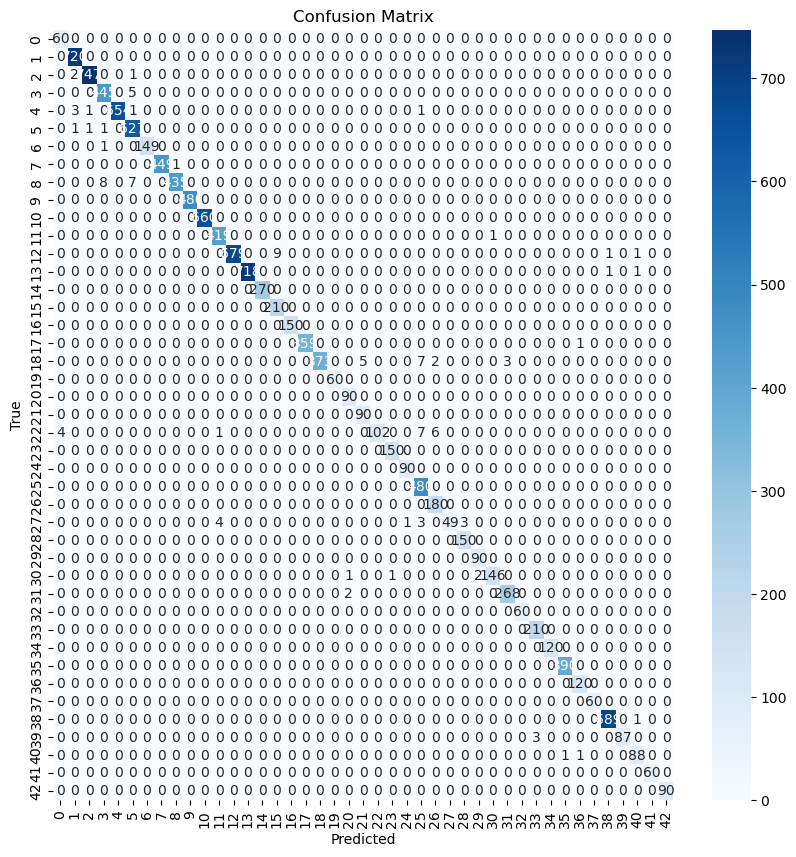

In [17]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.98      0.99      0.98       450
           4       1.00      0.99      1.00       660
           5       0.98      1.00      0.99       630
           6       1.00      0.99      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      1.00      0.99       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.96      1.00      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

### Load the model

In [19]:
# load the model
model = load_model('gtsrb_final_model.h5')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1